In [1]:
import json
import datetime
import requests as rq

import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from IPython.display import Image

from osgeo import gdal

import shapely
import shapely.wkt
import shapely.geometry
from shapely.geometry import shape
from shapely.ops import transform

import pyproj
from pyproj import Proj

import rasterio as rio
from rasterio.mask import mask
from rasterio.plot import show

gdal.SetConfigOption('GDAL_HTTP_COOKIEFILE', '~/cookies.txt')
gdal.SetConfigOption('GDAL_HTTP_COOKIEJAR', '~/cookies.txt')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN', 'YES')
gdal.SetConfigOption('CPL_VSIL_CURL_ALLOWED_EXTENSIONS', 'TIF')

mpl.rcParams['figure.dpi'] = 150

In [2]:
def getndvi(red, nir):
    return ((nir - red)/(nir + red))

def reproject_aoi(band, aoishape):
    wgs84 = Proj('+proj=longlat +datum=WGS84 +no_defs', preserve_units=True)
    utm = pyproj.Proj(band.crs)
    trans_utm = pyproj.Transformer.from_proj(wgs84, utm)
    utm_shapely_polygon = transform(trans_utm.transform, aoishape)

    return utm_shapely_polygon

def get_geojson_from_shapely_polygon(shapely_polygon):
    wktext = shapely.wkt.loads(str(shapely_polygon))
    json_str = json.dumps(shapely.geometry.mapping(wktext))

    geometry = [json.loads(json_str)]
    return geometry

In [3]:
gist = rq.get('https://gist.githubusercontent.com/thaisbendixen/e126c37a3fa021495414658eeaf86d8d/raw/5d1926dcb3a4b9d631521ba12ea79fdc1ecd2df7/doberitz_multipolygon.geojson')
geoj = gist.json()
geoj

{'type': 'FeatureCollection',
 'name': 'doberitz_multipolygon',
 'crs': {'type': 'name',
  'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}},
 'features': [{'type': 'Feature',
   'properties': {'id': None},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[13.018342362503612, 52.494439618439],
      [13.03784806830448, 52.49337926430886],
      [13.03784806830448, 52.49337926430886],
      [13.081387590181421, 52.46898406189582],
      [13.073376318156065, 52.45030729171344],
      [13.060140303505474, 52.45243005096449],
      [13.061185252030521, 52.45582625295585],
      [13.054915560880241, 52.45985890264111],
      [13.045859340329837, 52.45943443059282],
      [13.044814391804792, 52.453491392222496],
      [13.040634597704605, 52.44669836617253],
      [12.984904009702124, 52.47110592086133],
      [13.018342362503612, 52.494439618439]]]}},
  {'type': 'Feature',
   'properties': {'id': None},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[13.0340165903793

In [4]:
# Adding "poly_ID" to the two polygons in the multipolygon geojson for later use

for i in range(len(geoj['features'])):
    geoj['features'][i]['properties']['id'] = f"poly_{i+1}"

In [5]:
geoj

{'type': 'FeatureCollection',
 'name': 'doberitz_multipolygon',
 'crs': {'type': 'name',
  'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}},
 'features': [{'type': 'Feature',
   'properties': {'id': 'poly_1'},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[13.018342362503612, 52.494439618439],
      [13.03784806830448, 52.49337926430886],
      [13.03784806830448, 52.49337926430886],
      [13.081387590181421, 52.46898406189582],
      [13.073376318156065, 52.45030729171344],
      [13.060140303505474, 52.45243005096449],
      [13.061185252030521, 52.45582625295585],
      [13.054915560880241, 52.45985890264111],
      [13.045859340329837, 52.45943443059282],
      [13.044814391804792, 52.453491392222496],
      [13.040634597704605, 52.44669836617253],
      [12.984904009702124, 52.47110592086133],
      [13.018342362503612, 52.494439618439]]]}},
  {'type': 'Feature',
   'properties': {'id': 'poly_2'},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[13.03401

In [6]:
payload = {}
payload['end_date']=datetime.datetime.today().strftime("%Y-%m-%d")
payload['start_date']=(datetime.datetime.today() - datetime.timedelta(days=20)).strftime("%Y-%m-%d")
payload['aois']=geoj

In [7]:
payload

{'end_date': '2021-11-05',
 'start_date': '2021-10-16',
 'aois': {'type': 'FeatureCollection',
  'name': 'doberitz_multipolygon',
  'crs': {'type': 'name',
   'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}},
  'features': [{'type': 'Feature',
    'properties': {'id': 'poly_1'},
    'geometry': {'type': 'Polygon',
     'coordinates': [[[13.018342362503612, 52.494439618439],
       [13.03784806830448, 52.49337926430886],
       [13.03784806830448, 52.49337926430886],
       [13.081387590181421, 52.46898406189582],
       [13.073376318156065, 52.45030729171344],
       [13.060140303505474, 52.45243005096449],
       [13.061185252030521, 52.45582625295585],
       [13.054915560880241, 52.45985890264111],
       [13.045859340329837, 52.45943443059282],
       [13.044814391804792, 52.453491392222496],
       [13.040634597704605, 52.44669836617253],
       [12.984904009702124, 52.47110592086133],
       [13.018342362503612, 52.494439618439]]]}},
   {'type': 'Feature',
    'properties

In [8]:
payload['aois']['features'][0]['geometry']

{'type': 'Polygon',
 'coordinates': [[[13.018342362503612, 52.494439618439],
   [13.03784806830448, 52.49337926430886],
   [13.03784806830448, 52.49337926430886],
   [13.081387590181421, 52.46898406189582],
   [13.073376318156065, 52.45030729171344],
   [13.060140303505474, 52.45243005096449],
   [13.061185252030521, 52.45582625295585],
   [13.054915560880241, 52.45985890264111],
   [13.045859340329837, 52.45943443059282],
   [13.044814391804792, 52.453491392222496],
   [13.040634597704605, 52.44669836617253],
   [12.984904009702124, 52.47110592086133],
   [13.018342362503612, 52.494439618439]]]}

In [235]:
shape_polygon = shape(payload['aois']['features'][1]['geometry'])
bounds = list(shape_polygon.bounds)
bbounds = str(bounds).replace(' ','')

In [236]:
bbounds

'[13.009286141953213,52.46495224803063,13.105769722432509,52.53407850506677]'

In [237]:
# #searching for COGs in AWS

url = f"https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items?limit=550&bbox={bbounds}&datetime={payload['start_date']}T00:00:00Z/{payload['end_date']}T23:59:59Z"

print(url)

try:
    search_response = rq.get(url).json()
except Exception as e:
    print(e)
    print('\nSentinel-2 AWS URL failed')

items = search_response['features']

# print(items)

bandlist = []
for item in items:
    if item['properties']['eo:cloud_cover'] < 10:
        image = [
            item['assets']['thumbnail']['href'], # PNG/JPG True Color
            item['properties']['datetime'].split('T')[0],  # DATE in format - 2021-01-01T21:31:13Z 
            item['assets']['B04']['href'],  # RED
            item['assets']['B08']['href'],  # NIR
            item['assets']['visual']['href']] # TIF true color
        bandlist.append(image)

https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items?limit=550&bbox=[13.009286141953213,52.46495224803063,13.105769722432509,52.53407850506677]&datetime=2021-10-16T00:00:00Z/2021-11-05T23:59:59Z


In [238]:
bandlist

[['https://roda.sentinel-hub.com/sentinel-s2-l1c/tiles/32/U/QD/2021/10/28/0/preview.jpg',
  '2021-10-28',
  'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/32/U/QD/2021/10/S2B_32UQD_20211028_0_L2A/B04.tif',
  'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/32/U/QD/2021/10/S2B_32UQD_20211028_0_L2A/B08.tif',
  'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/32/U/QD/2021/10/S2B_32UQD_20211028_0_L2A/TCI.tif'],
 ['https://roda.sentinel-hub.com/sentinel-s2-l1c/tiles/33/U/UU/2021/10/28/0/preview.jpg',
  '2021-10-28',
  'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/33/U/UU/2021/10/S2B_33UUU_20211028_0_L2A/B04.tif',
  'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/33/U/UU/2021/10/S2B_33UUU_20211028_0_L2A/B08.tif',
  'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/33/U/UU/2021/10/S2B_33UUU_20211028_0_L2A/TCI.tif']]

In [239]:
# remove duplicates/double images per day captured within seconds of each other

to_run = {}

for items in bandlist:
    if items[1] in to_run.keys():
        continue
    else:
        to_run[items[1]] = items

bandlist = list(to_run.values())[0]

In [240]:
bandlist[0]

'https://roda.sentinel-hub.com/sentinel-s2-l1c/tiles/32/U/QD/2021/10/28/0/preview.jpg'

In [241]:
bandlist

['https://roda.sentinel-hub.com/sentinel-s2-l1c/tiles/32/U/QD/2021/10/28/0/preview.jpg',
 '2021-10-28',
 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/32/U/QD/2021/10/S2B_32UQD_20211028_0_L2A/B04.tif',
 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/32/U/QD/2021/10/S2B_32UQD_20211028_0_L2A/B08.tif',
 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/32/U/QD/2021/10/S2B_32UQD_20211028_0_L2A/TCI.tif']

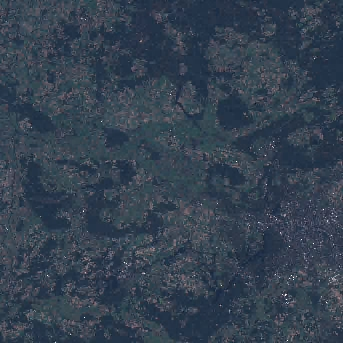

In [242]:
Image(bandlist[0])

In [243]:
date = bandlist[1]
b4 = bandlist[2]
b8 = bandlist[3]

print('Processing SM for date :', date, 'from link :', b4)

print('\nOpening red band')

try:
    red = rio.open(b4)
except Exception as e:
    print('\n Issue with Sentienl-2 S3 Link :', e)

print('\nOpening nir band')
nir = rio.open(b8)

Processing SM for date : 2021-10-28 from link : https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/32/U/QD/2021/10/S2B_32UQD_20211028_0_L2A/B04.tif

Opening red band

Opening nir band


In [244]:
red.crs.data['init']

'epsg:32632'

In [245]:
get_geojson_from_shapely_polygon(shape_polygon)

[{'type': 'Polygon',
  'coordinates': [[[13.03401659037931, 52.53174779561826],
    [13.0538706123552, 52.53407850506677],
    [13.07442126668112, 52.53132401697322],
    [13.10019666363226, 52.52772173337492],
    [13.10576972243251, 52.51903265726568],
    [13.10124161215731, 52.50673785788637],
    [13.09497192100703, 52.48150155115215],
    [13.09497192100703, 52.46749869975319],
    [13.08452243575656, 52.46495224803063],
    [13.07581453138118, 52.46749869975319],
    [13.0674549431808, 52.47471284633612],
    [13.06362346525563, 52.48341068566231],
    [13.05456724470523, 52.49104639522103],
    [13.04760092120492, 52.49634819144144],
    [13.03680311977944, 52.49995304776128],
    [13.02217384042879, 52.50164934846698],
    [13.0134659360534, 52.5086458970592],
    [13.00928614195321, 52.51776094098375],
    [13.01172435517832, 52.52517876705363],
    [13.03401659037931, 52.53174779561826]]]}]

In [246]:
# converting shape to UTM projection
utm_shape = reproject_aoi(red, shape_polygon)

In [247]:
get_geojson_from_shapely_polygon(utm_shape)

[{'type': 'Polygon',
  'coordinates': [[[773585.4074698, 5827833.065531038],
    [774916.741552704, 5828167.670194156],
    [776327.1021383319, 5827940.043457103],
    [778097.1950991005, 5827638.718034534],
    [778530.0433208011, 5826694.363442391],
    [778300.7565328134, 5825310.210529375],
    [778034.818810839, 5822480.802653862],
    [778123.1975702529, 5820924.267546925],
    [777429.82727533, 5820600.983432287],
    [776822.6303668004, 5820850.602667468],
    [776209.8843159785, 5821620.486645048],
    [775895.3334014218, 5822572.674811134],
    [775233.0128149395, 5823386.866725073],
    [774727.2445572412, 5823949.660128579],
    [773972.233262104, 5824309.309389871],
    [772969.2691739245, 5824442.407383269],
    [772335.2530084151, 5825187.236670328],
    [771995.3992000902, 5826184.707516448],
    [772114.8477672858, 5827018.485869613],
    [773585.4074698, 5827833.065531038]]]}]

In [248]:
# clipping array to slightly larger AOI
print('clipping nir band')
nir_array, nir_transform = mask(
    nir, get_geojson_from_shapely_polygon(utm_shape), crop=True)
print('clipping red band')
red_array, red_transform = mask(
    red, get_geojson_from_shapely_polygon(utm_shape), crop=True)

clipping nir band
clipping red band


In [249]:
SCALE = 0.001 # scaling applied to Sen-2A images to reduce image size, applied back to get ideal NDVI values

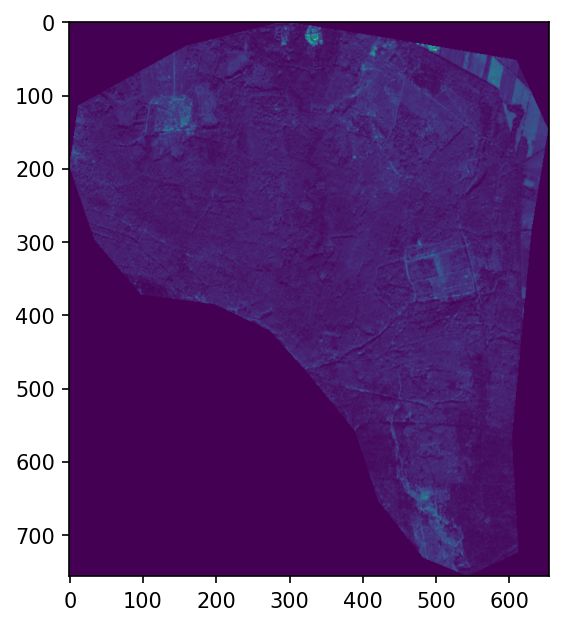

In [250]:
plt.imshow(red_array[0])
plt.show()

In [251]:
ndvi = getndvi(red_array[0]*SCALE, nir_array[0]*SCALE)

<ipython-input-2-32345c2705f2>:2: RuntimeWarning: invalid value encountered in true_divide
  return ((nir - red)/(nir + red))


In [252]:
np.count_nonzero(np.isnan(ndvi))

199437

In [253]:
ndvi

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [254]:
np.nan_to_num(ndvi,0)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [255]:
np.count_nonzero(np.isnan(ndvi))

0

In [256]:
np.nan_to_num(data,0)

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

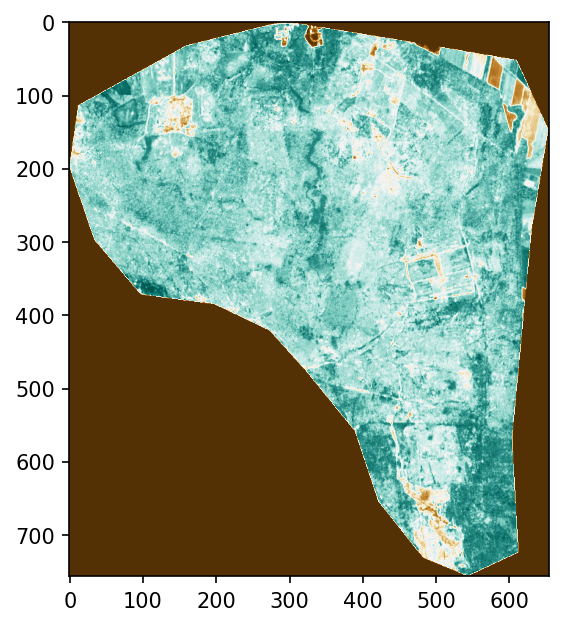

In [257]:
plt.imshow(ndvi,vmin=0,vmax=1,cmap='BrBG')
plt.show()

In [258]:
data = np.empty((ndvi.shape[0]*ndvi.shape[1],1))

In [259]:
data.shape

(495835, 1)

In [260]:
data[:, 0] = ndvi.flatten()

In [261]:
data.min()

-0.06498123642109424

In [262]:
from sklearn.cluster import KMeans

In [278]:
km = KMeans(n_clusters=3,random_state=0)
km.fit(data)
km.predict(data)

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [279]:
out_dat = km.labels_.reshape((ndvi.shape[0], ndvi.shape[1]))

In [280]:
tci = rio.open(bandlist[4])

In [281]:
tci_array, tci_transf = mask(tci,get_geojson_from_shapely_polygon(utm_shape),crop=True)

In [284]:


#produce colormap with as many colors as there are unique values in df
colors = ["white", "limegreen","green"]  # use hex colors here, if desired.
cmap = ListedColormap(colors)

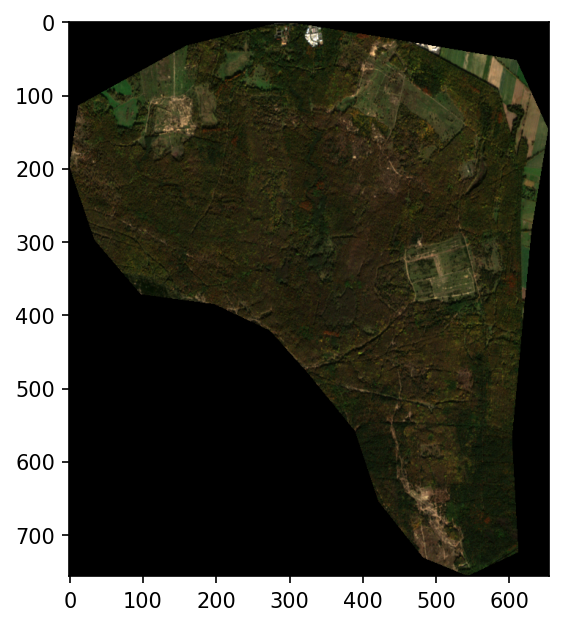

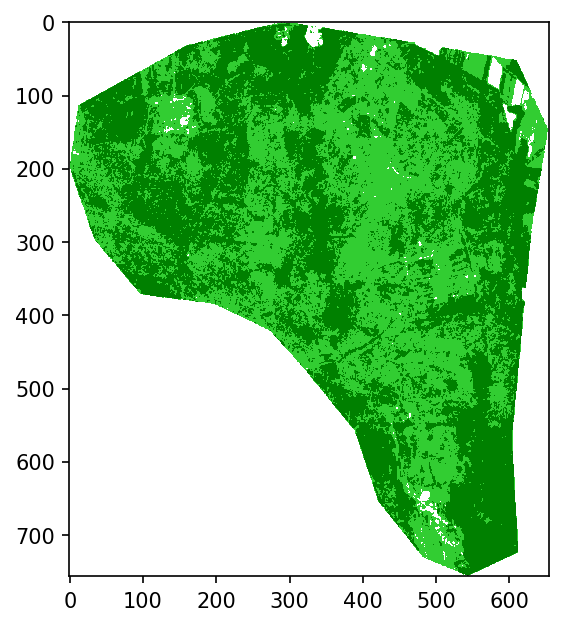

<AxesSubplot:>

In [285]:
show(tci_array)
show(out_dat,cmap=cmap)

In [231]:
np.unique(out_dat, return_counts = True)

(array([0, 1, 2, 3], dtype=int32), array([158596, 132006,  49256,   4276]))

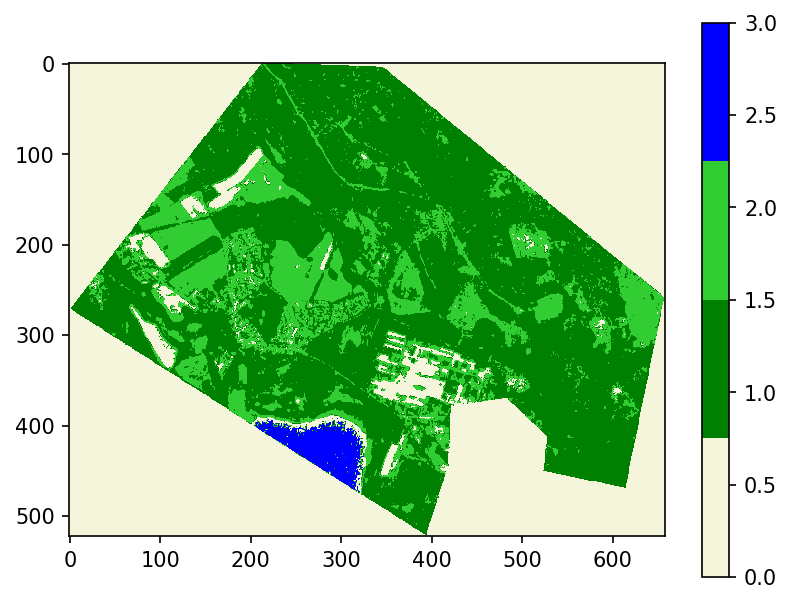

In [234]:
plt.imshow(out_dat,cmap=cmap)

plt.savefig('4_classes_poly_2.png')
plt.colorbar()
plt.show()